<a href="https://colab.research.google.com/github/vrlnarayana/IsolationForest/blob/master/Capstone_Recommendation_Systems_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project : Group 4 : Song Recommendation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from google.colab import files
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')

# Remove scientific notations and display numbers with 2 decimal points instead
pd.options.display.float_format = '{:,.2f}'.format   

plt.rcParams["figure.figsize"] = [20, 6]  # width, height
plt.rcParams['xtick.direction'] = 'out'

**READ SONG DATA**

In [3]:
song_data=pd.read_csv(r'/content/drive/My Drive/song_data.csv')

**READ PLAY COUNT DATA**

In [4]:
count_data=pd.read_csv(r'/content/drive/My Drive/count_data.csv', index_col='Unnamed: 0') #Making unnamed: 0 an index column

**READ IMDb RATING DATA - "Externally Added"**

In [5]:
df_rating_data=pd.read_csv(r'/content/drive/My Drive/rating data.tsv', sep='\t')

**READ IMDb MOVIE TITLES DATA - "Externally Added"**

In [6]:
df_akas_data=pd.read_csv(r'/content/drive/My Drive/akas data.tsv', sep='\t')

In [ ]:
song_data.head()

In [ ]:
count_data.head()

In [ ]:
df_rating_data.head()

In [ ]:
df_akas_data.head()

**COMMENT:**
millionsongs dataset and IMDb have different indexes/keys and hence we need to analyse and see how to join based on common movie title. If there is no match, we need to find an alternate solution

# Exploratory data Analysis

In [ ]:
count_data.info()

In [12]:
song_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   song_id      1000000 non-null  object
 1   title        999985 non-null   object
 2   release      999995 non-null   object
 3   artist_name  1000000 non-null  object
 4   year         1000000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 38.1+ MB


**COMMENTS**
1.   year and paly_count are an int column in song_data and count_data
2.   **15 titles and 5 releases are null values**



In [13]:
rows, columns = count_data.shape
print("No of rows: ", rows) 
print("No of columns: ", columns)

No of rows:  2000000
No of columns:  3


In [14]:
rows, columns = song_data.shape
print("No of rows: ", rows) 
print("No of columns: ", columns)

No of rows:  1000000
No of columns:  5


In [15]:
count_data.describe()

,play_count
count,"2,000,000.00"
mean,3.05
std,6.58
min,1.00
25%,1.00
50%,1.00
75%,3.00
max,"2,213.00"


In [16]:
song_data.describe()

,year
count,"1,000,000.00"
mean,"1,030.33"
std,998.75
min,0.00
25%,0.00
50%,"1,969.00"
75%,"2,002.00"
max,"2,011.00"


**COMMENT:**
**Song data has some year values 0, which may not be useful in the analysis**



In [17]:
df_rating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1106685 entries, 0 to 1106684
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1106685 non-null  object 
 1   averageRating  1106685 non-null  float64
 2   numVotes       1106685 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 25.3+ MB


In [18]:
df_akas_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24662400 entries, 0 to 24662399
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   titleId          object
 1   ordering         int64 
 2   title            object
 3   region           object
 4   language         object
 5   types            object
 6   attributes       object
 7   isOriginalTitle  object
dtypes: int64(1), object(7)
memory usage: 1.5+ GB


In [19]:
df_rating_data.describe()

,averageRating,numVotes
count,"1,106,685.00","1,106,685.00"
mean,6.88,954.49
std,1.41,"15,978.59"
min,1.00,5.00
25%,6.10,9.00
50%,7.10,20.00
75%,7.90,78.00
max,10.00,"2,324,072.00"


**COMMENTS:**
1.   AverageRating has **rating 1 to 10.**
2.   numVotes shows a **huge SKEW**



In [20]:
song_data.isnull().sum()

song_id         0
title          15
release         5
artist_name     0
year            0
dtype: int64

**COMMENT**
**In Song data 15 titles and 5 releases are null values**

In [21]:
print('No of unique artists in the data=> ',song_data.artist_name.nunique())

No of unique artists in the data=>  72665


In [22]:
count_data.isnull().sum()

user_id       0
song_id       0
play_count    0
dtype: int64

**COMMENT**
**Play Count data has no null values**

# Checking Duplicates in Song Data

In [23]:
song_data.duplicated().value_counts()

False    999502
True        498
dtype: int64

**COMMENT**
**Song data has 498 duplicates**, we will have treat duplicates before grouping and analysing data

In [24]:
count_data.duplicated().any()

False

**COMMENTS**
**Count data has no duplicates**

In [25]:
# Checking for duplicated rows in song data
song_data[song_data.duplicated()] #Duplicates are 498 in count

,song_id,title,release,artist_name,year
18309,SOPFBUZ12AF729C896,Spitting Games,Final Straw,Snow Patrol,2003
32760,SOJHKXX12A8C139798,A Crow Left Of The Murder,Live in Malaysia 2004,Incubus,2004
54218,SONVJUL12A6701FB7A,The Damage In Your Heart,Make Believe,Weezer,2005
73174,SORBGBD12A8C141CEA,Weight Of The World,The Open Door,Evanescence,2006
83415,SONLOQQ12A8C139AF9,Go To Sleep,Hail To The Thief,Radiohead,2003
...,...,...,...,...,...
997476,SOCGXXL12B0B808865,Yesterdays,Greatest Hits,Guns N' Roses,1991
998785,SOEUIVS12A8C1400E3,Someone Put Your Hand Out,King Of Pop,Michael Jackson,1992
999365,SORANLE12A6310DBC8,Long Way To Go,Love Angel Music Baby,Gwen Stefani / Andre 3000,0
999643,SOAPUFN12AB017FF03,Suggestions,System Of A Down (Bonus Pack),System of a Down,1998


In [26]:
# Checking a sample data
song_data[song_data.song_id=='SOPFBUZ12AF729C896']

,song_id,title,release,artist_name,year
7055,SOPFBUZ12AF729C896,Spitting Games,Final Straw,Snow Patrol,2003
18309,SOPFBUZ12AF729C896,Spitting Games,Final Straw,Snow Patrol,2003


# Treating Duplicates in Song Data

In [27]:
# DROPPING DUPLICATES in SONG DATA with inplace=True
song_data.drop(song_data[song_data.duplicated()].index, inplace=True)

In [28]:
# CHECKING DUPLICATES AGAIN TO CONFIRM
song_data.duplicated().any()

False

# Checking null values in song title and release column

In [29]:
nan_song_df=song_data[song_data.title.isnull() | song_data.release.isnull()]
nan_song_df

,song_id,title,release,artist_name,year
64262,SOVICLT12A58A7C4D0,NaN,Of Flies And Men,Milton,0
114672,SOAGRAA12AB018D567,NaN,Puce de luxe,Sébastien Roch,0
138011,SOOBGAQ12A6D4F6762,Solitude,NaN,Metro,0
197822,SOGFJER12A6D4F675F,All The Beautiful People,NaN,Metro,0
223019,SOAFJBH12A6D4F6765,Down The Aisles,NaN,Metro,0
229353,SOOAFJX12AB018A028,NaN,Puce de luxe,Sébastien Roch,0
264639,SOLDTFD12AB018AFE6,NaN,Puce de luxe,Sébastien Roch,0
458083,SOAUTVB12AB018AFF0,NaN,Puce de luxe,Sébastien Roch,0
557125,SOMPGYE12AB018AFE0,NaN,Puce de luxe,Sébastien Roch,0
578241,SOVHAZH12AB018D5B3,NaN,Puce de luxe,Sébastien Roch,0


**Checking null values in song title and release has any impact on play count data**
**If there is no play count data available for the Null titles and releases then we can ignore them as they will not impact our analysis** 

In [30]:
count_data.song_id.isin(nan_song_df.song_id).value_counts() 

False    2000000
Name: song_id, dtype: int64

**COMMENT:**
value_counts provides a False output which means there is **NO IMPACT** null titles do not have play counts. Hence, **IGNORE THEM NULL TITLES and RELEASES**

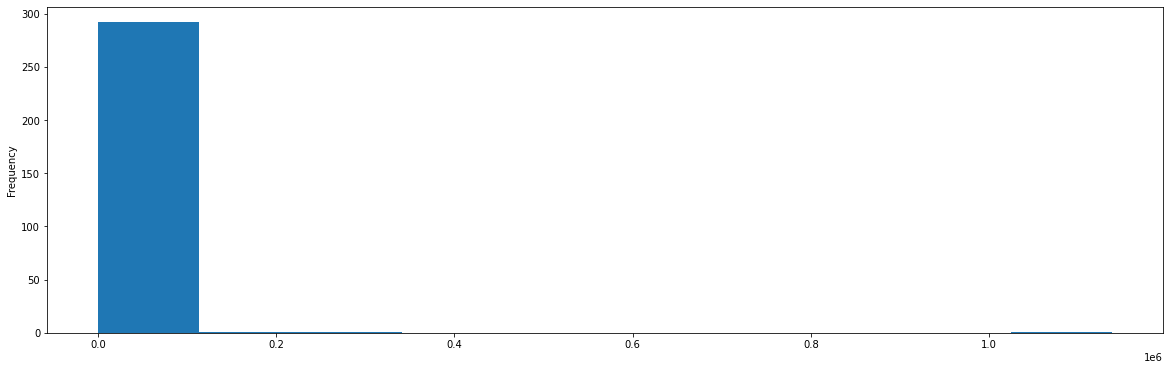

In [31]:
#HIST plot to see the concentration of user play_counts. We can see the count is more in the lower rungs, with an exception of a few in the higher rungs
count_data.play_count.value_counts().plot(bins=10,kind='hist')

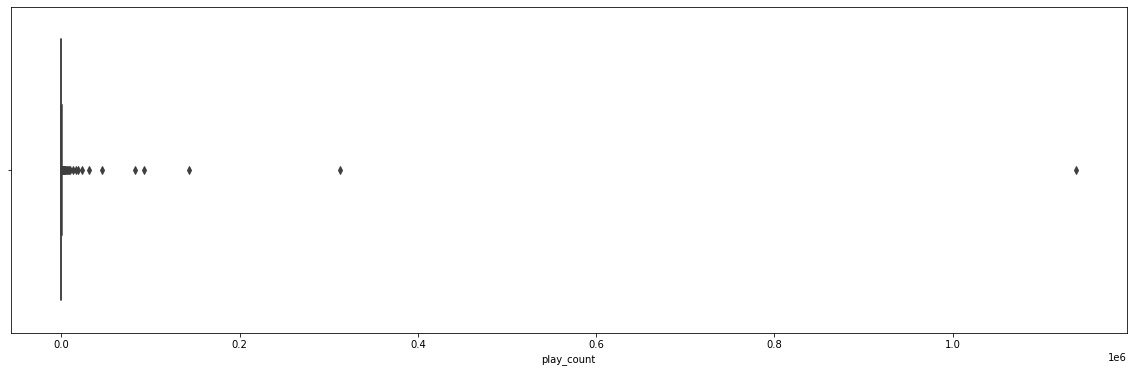

In [32]:
# Confirming the same with boxplot
sns.boxplot(count_data.play_count.value_counts())

# Grouping and Merging DataSets

In [33]:
sorted_play_counts_df=count_data.groupby(['song_id','play_count']).sum().sort_values(by='play_count',ascending=False)
sorted_play_counts_df.reset_index(inplace=True)
sorted_play_counts_df.set_index('song_id', inplace=True)# making song_id index of the df, this is required to merge with song_data df

sorted_play_counts_df # Sorted in descending order of play_count to see the top play counts first


,play_count,user_id
song_id,,
SOFCGSE12AF72A674F,2213,d13609d62db6df876d3cc388225478618bb7b912
SOUAGPQ12A8AE47B3A,920,50996bbabb6f7857bf0c8019435b5246a0e45cfd
SOKOSPK12A8C13C088,879,5ea608df0357ec4fda191cb9316fe8e6e65e3777
SOZQSVB12A8C13C271,796,bb85bb79612e5373ac714fcd4469cabeb5ed94e1
SOBONKR12A58A7A7E0,683,c012ec364329bb08cbe3e62fe76db31f8c5d8ec3
...,...,...
SOPRQRO12AB018906E,1,25fc0200450bbf726c8511fabe31ecfdb81732eb3fd3ac...
SOPROPB12A8C1385BD,1,732f88be38fae217f8ab7e24c20dd072436e3e40b12c78...
SOPROEW12A6D4FD0F7,1,4691b4c353503da2c108e372ff056a9ac847c4d1fb51c7...


In [ ]:
songs_play_count_df=pd.merge(sorted_play_counts_df,song_data,on='song_id')

In [ ]:
songs_play_count_df

**COMMENT**
**songs_play_count_df has total rows of 142490 rows afer pd merge**

[Text(0, 0, '0'),
 Text(0, 0, '1954'),
 Text(0, 0, '1955'),
 Text(0, 0, '1956'),
 Text(0, 0, '1957'),
 Text(0, 0, '1958'),
 Text(0, 0, '1959'),
 Text(0, 0, '1960'),
 Text(0, 0, '1961'),
 Text(0, 0, '1962'),
 Text(0, 0, '1963'),
 Text(0, 0, '1964'),
 Text(0, 0, '1965'),
 Text(0, 0, '1966'),
 Text(0, 0, '1967'),
 Text(0, 0, '1968'),
 Text(0, 0, '1969'),
 Text(0, 0, '1970'),
 Text(0, 0, '1971'),
 Text(0, 0, '1972'),
 Text(0, 0, '1973'),
 Text(0, 0, '1974'),
 Text(0, 0, '1975'),
 Text(0, 0, '1976'),
 Text(0, 0, '1977'),
 Text(0, 0, '1978'),
 Text(0, 0, '1979'),
 Text(0, 0, '1980'),
 Text(0, 0, '1981'),
 Text(0, 0, '1982'),
 Text(0, 0, '1983'),
 Text(0, 0, '1984'),
 Text(0, 0, '1985'),
 Text(0, 0, '1986'),
 Text(0, 0, '1987'),
 Text(0, 0, '1988'),
 Text(0, 0, '1989'),
 Text(0, 0, '1990'),
 Text(0, 0, '1991'),
 Text(0, 0, '1992'),
 Text(0, 0, '1993'),
 Text(0, 0, '1994'),
 Text(0, 0, '1995'),
 Text(0, 0, '1996'),
 Text(0, 0, '1997'),
 Text(0, 0, '1998'),
 Text(0, 0, '1999'),
 Text(0, 0, '200

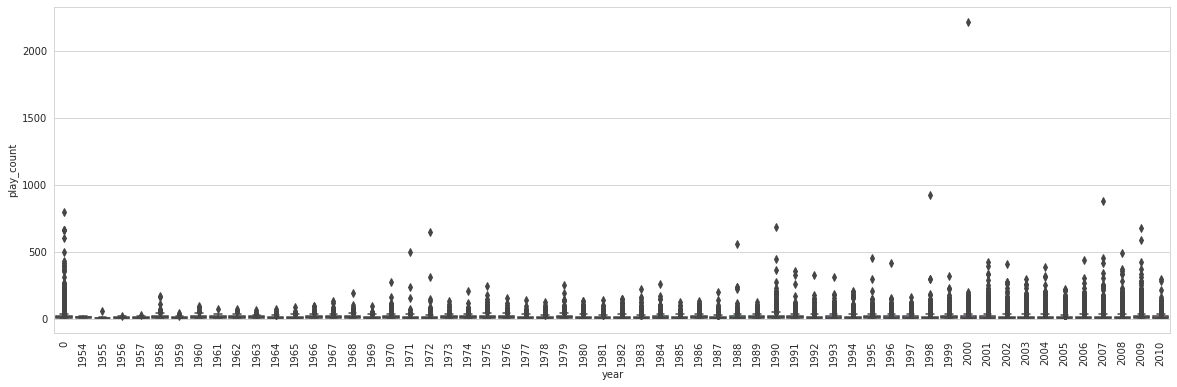

In [75]:
sns.set_style("whitegrid")
ax = sns.boxplot(x="year", y="play_count", data=songs_play_count_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

**Sudeep Comment :** From the above Boxplot chart it can be said that the song play count increased from the year 1990 onwards. This may be due to more availability of compact dics & improved internet connection over the years.

In [ ]:
songs_play_count_df.isnull().any() # reconfirming presence of any null values.

**There are no null values**

In [ ]:
songs_play_count_df[songs_play_count_df['song_id']=='SOBONKR12A58A7A7E0']

**COMMENT:**
specific song_id = **SOFCGSE12AF72A674F** show that a user_id = **d13609d62db6df876d3cc388225478618bb7b912** has played it 2213 times, must be a crazy listner as the next best is only 26

In [ ]:
# Release'wise sorted play count (Top 10)
release_play_count_df=songs_play_count_df[['release','play_count']].groupby('release').sum().sort_values(by='play_count',ascending=False)[:10]
release_play_count_df

In [ ]:
# Artist'wise play count top 10
artist_play_count_df=songs_play_count_df[['artist_name','play_count']].groupby('artist_name').sum().sort_values(by='play_count',ascending=False)[:10]
artist_play_count_df

In [ ]:
# artist and release 'wise top 10
artist_release_play_count_df=songs_play_count_df[['artist_name','release','play_count']].groupby(['artist_name','release']).sum().sort_values(by='play_count',ascending=False)[:10]
artist_release_play_count_df

# Filtering songs data based on top play counts

In [ ]:
top_count_data=count_data[count_data.play_count>20] # considering play_count greater than 20

In [ ]:
print('The number of observations in top_count_data =', len(top_count_data))
print('Number of unique USERS in top_count_data = ', top_count_data['user_id'].nunique())
print('Number of unique SONGS in top_count_data = ', top_count_data['song_id'].nunique())

# Popularity based recommendation

In [ ]:
popular_song_df = top_count_data.groupby('song_id').play_count.agg(['sum']).sort_values(by='sum',ascending=False)
popular_song_df.head(10) #Popularity based top 10 songs played. 
 # TO be discussed with Lakshminaryanan

In [ ]:
# Making a dataframe where we have summation of times song is played in general and played by distincet users i.e count_play_count.(Number of times we have play_count for the users)
sum_play_count = songs_play_count_df.groupby('song_id').sum()['play_count']
count_play_count = songs_play_count_df.groupby('song_id').count()['play_count']
final_play_count=pd.DataFrame({'sum_play_count':sum_play_count,'count_play_count':count_play_count})

In [ ]:
final_play_count.sort_values(by='count_play_count', ascending=False)

In [ ]:
#defining a function to get the top n songs based on highest times a song is played in general and some minimum interactions (minimum number of distinct users or we can say play count) of that song
def top_n_songs(final_play_count, n, min_interaction=50):
    recommendations=final_play_count[final_play_count['count_play_count']>min_interaction]
    recommendations=recommendations.sort_values(by='sum_play_count', ascending=False)
    return recommendations.index[:n]

In [ ]:
# Top 5 songs based on atleast 50 interactions between users and the song. 
top_pop_songs_id=list(top_n_songs(final_play_count, 10, 50))
top_pop_songs_id

In [ ]:
song_data[song_data.song_id.isin(top_pop_songs_id)].set_index('song_id').title

In [49]:
choices=np.unique(song_data[song_data.song_id.isin(top_pop_songs_id)].title.values)+' by '+np.unique(song_data[song_data.song_id.isin(top_pop_songs_id)].artist_name.values)

In [ ]:
choices,len(choices)

# Collaborative filtering based recommendation

**Interaction Matrix - play_count_data**

In [51]:
play_count_data_matrix = top_count_data.pivot(index='user_id', columns='song_id', values='play_count').fillna(0)
play_count_data_matrix

song_id,SOAAAGQ12A8C1420C8,SOAACPJ12A81C21360,SOAACSG12AB018DC80,SOAAFAC12A67ADF7EB,SOAAFYH12A8C13717A,SOAAKPM12A58A77210,SOAALWN12A6D4F7FDA,SOAAOYI12AB01831CE,SOAAROC12A6D4FA420,SOAATLI12A8C13E319,SOAAUKC12AB017F868,SOAAVUV12AB0186646,SOAAWEE12A6D4FBEC8,SOABHNP12A8AE46E82,SOABHYV12A6D4F6D0F,SOABJBU12A8C13F63F,SOABJTC12A58A7DE0E,SOABNLP12A6D4F87F4,SOABNPW12A6D4FC9B5,SOABOHM12AB018509C,SOABOXV12AC3DF82F7,SOABQTG12A6701F3DB,SOABTTR12A6D4FC2EB,SOABXNE12A8C13B818,SOACBLB12AB01871C7,SOACIPG12A8AE47E1C,SOACKIA12A6D4F73D7,SOACMJJ12A6D4FC66A,SOACNQJ12A8C13B09E,SOACPSU12A81C231EF,SOACYUL12A6D4F9C79,SOADELR12AB0181A6D,SOADISH12AB018DFAC,SOADJGO12AB0185D5B,SOADJQJ12A8C141D38,SOADMBB12AB017C0F1,SOADMKP12A8C13BAA4,SOADMTV12A6701FA3F,SOADOQJ12A8AE45C7E,SOADQMO12A8C136FF9,...,SOZVCRW12A67ADA0B7,SOZVSSP12AB01819DE,SOZVTFB12AF729FEAA,SOZVUCT12A8C1424BE,SOZVVMJ12A58A7C548,SOZVVRE12A8C143150,SOZVYSU12A6310F227,SOZVZSP12A6D4F6A99,SOZWBVE12AAF3B515C,SOZWDQN12AB0182A85,SOZWJEP12A6310E1F5,SOZWLHR12A8C13F211,SOZWMNZ12A6D4FCD0D,SOZWNXK12AF729D82B,SOZWQWC12AF72AAA2C,SOZWVZW12AF72A0E04,SOZWWTF12A8C1408E2,SOZXBVL12AB0184D35,SOZXHNM12AB017CDEA,SOZXHRP12A6D4F9A2C,SOZXHYA12A8C145274,SOZXKIA12A6D4F861C,SOZXLPJ12A6701F7AB,SOZXMYX12AB018A445,SOZXTAI12A8C134DE1,SOZXTUT12A6D4F6D03,SOZXVWK12AB018B865,SOZYDZR12A8C13F4F0,SOZYIQR12A58A7DB25,SOZYPRF12A6310F1B4,SOZYSDT12A8C13BFD7,SOZYUGZ12A8AE472AC,SOZYUXF12A6701F7B9,SOZZHQT12AB018B714,SOZZKPR12A6D4F8147,SOZZLTY12A67AE0AD0,SOZZLZN12A8AE48D6D,SOZZTCU12AB0182C58,SOZZTNF12A8C139916,SOZZWZV12A67AE140F
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00125672fad06bc57f5a4304cceea9effab07839,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0013e651c18f10396ad1125d5d1c894b0224bb1f,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0021d9a4628624f6d70237f9c200ab82e766bf26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0022c3932761ce91d8a034318402cfb63224f894,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
002543003041db1d049206b09426d5cdffc0f451,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
available_play_counts = np.count_nonzero(play_count_data_matrix)
print('available_play_counts = ', available_play_counts)
possible_num_of_play_counts = play_count_data_matrix.shape[0] * play_count_data_matrix.shape[1]
print('possible_num_of_play_counts = ', possible_num_of_play_counts)
density = (available_play_counts/possible_num_of_play_counts)
density *= 100
print ('density: {:4.2f}%'.format(density))

**COMMENT:**
**Density is low, means data is sparse**

# Merge IMDb with Song Data

In [ ]:
imdb_merge=pd.merge(df_akas_data,df_rating_data,left_on='titleId',right_on='tconst')

**COMMENT:**
IMDb song titles and IMDb ratings data merged

In [ ]:
imdb_merge=imdb_merge[imdb_merge.ordering==1] #filtering further to remove duplicate titles

In [55]:
imdb_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831682 entries, 0 to 3043874
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   titleId          831682 non-null  object 
 1   ordering         831682 non-null  int64  
 2   title            831682 non-null  object 
 3   region           831669 non-null  object 
 4   language         831682 non-null  object 
 5   types            831682 non-null  object 
 6   attributes       831682 non-null  object 
 7   isOriginalTitle  831682 non-null  object 
 8   tconst           831682 non-null  object 
 9   averageRating    831682 non-null  float64
 10  numVotes         831682 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 76.1+ MB


In [ ]:
imdb_merge[imdb_merge.title=='Silent Night'] #Silent Night, Carmencita, Tomorrow Is Ours

In [ ]:
song_imdb_merge=pd.merge(songs_play_count_df,imdb_merge,left_on='title',right_on='title') #Song data and IMDb rating data merged

In [ ]:
song_imdb_merge.set_index('song_id',inplace=True) #Song data and IMDb rating data merged

**COMMENT:**
ABOVE DATA song_imdb_merge is of different regions and hence to get universal rating we can do an average of all regions and sum of numVotes

# Popularity of Songs based on rating and numVotes

In [ ]:
#Top 10 averageRating across all regions (without filtering based on numVotes)
song_imdb_merge.groupby(['song_id','title','release'])['averageRating'].agg(['mean','count']).sort_values(by='count',ascending=False)[:10] 

In [ ]:
avg_rating = song_imdb_merge.groupby(['song_id','title','release']).sum()['averageRating']
rating_count = song_imdb_merge.groupby(['song_id','title','release']).count()['averageRating']
final_rating = pd.DataFrame({'avg_rating': avg_rating, 'rating_count': rating_count})

In [ ]:
def top_rated_n_songs(song_imdb_merge, n, min_interaction=20):
    recommendations=song_imdb_merge[song_imdb_merge['numVotes']>min_interaction]
    recommendations=recommendations.sort_values(by='averageRating', ascending=False)
    return recommendations.index[:n]

In [ ]:
top_rated_n_songs(song_imdb_merge,5)

In [ ]:
song_imdb_merge[song_imdb_merge['numVotes']>20]

In [ ]:
song_imdb_merge.averageRating.plot(kind='hist') #most of the rating has happened in the range of 6 to 9 and hence, we can take averageRating greater than 5

In [ ]:
song_imdb_merge.numVotes.plot(bins=1000,kind='hist') # This means there are 800 data points within every bin (total no of bins=1000=no of rows in the dataset)
# What we see here is, the peak is in the first few bins, plotly express below will give a clear view

In [66]:
fig = px.histogram(song_imdb_merge,x=song_imdb_merge.numVotes,nbins=100000,title='Plot Frequency')
fig.show()
#in IMDb Voting, rating dataset for the matching songs in MillionSongs Dataset significant no of votes are in this range
#192K counts in 0-499 Votes -> 0-99 Votes has 152K counts -> 100-199 Votes has 18.12K counts
#12.6K counts in 500-999 Votes
#
#So this means, we should consider numVotes < 1000 for filtering

In [ ]:
#numVotes distribution across songs
fig1 = px.line(song_imdb_merge,x=song_imdb_merge.index,y='numVotes',title='Plot Frequency')
fig1.show()

In [ ]:
#playcount distribution across songs
fig2 = px.line(song_imdb_merge,x=song_imdb_merge.index,y='play_count',title='Plot Frequency')
fig2.show()

In [ ]:
#histogram distribution across songs
fig3 = px.histogram(song_imdb_merge,x=song_imdb_merge.play_count,nbins=1000,title='Plot Frequency')
fig3.show()

In [ ]:
song_imdb_merge

In [ ]:
# Simulation of above histogram through code
cnt=[]
song_imdb_merge1=song_imdb_merge.reset_index()
playcnt=[10,20,30,40,50,60,70,80,90,100,150,200,300,400,500,1000]
for i in range(len(playcnt)):
  cnt.append(song_imdb_merge1.reset_index()[(song_imdb_merge1.play_count>playcnt[i]-playcnt[i-1])&(song_imdb_merge1.play_count<playcnt[i])].count()['song_id'])

dfplaycnt=pd.DataFrame({'playcount':playcnt,'counts':cnt}).set_index('playcount')
dfplaycnt

In [72]:
fig4 = px.line(dfplaycnt,x=dfplaycnt.index,y='counts',title='Plot playcounts bin')
fig4.show()
#This shows interesing graph playcount 20 DIPS drastically that means we can consider play_count>20 

In [ ]:
# Simulation of above histogram through code for numVotes
cnt=[]
numvotes=[10,20,30,40,50,60,70,80,90,100,150,200,300,400,500,1000,10000,100000,200000,300000,500000,800000,1000000]
for i in range(len(numvotes)):
  cnt.append(song_imdb_merge1[(song_imdb_merge1.numVotes>numvotes[i]-numvotes[i-1])&(song_imdb_merge1.numVotes<numvotes[i])].count()['song_id'])

dfnumvotes=pd.DataFrame({'numvotes':numvotes,'counts':cnt}).set_index('numvotes')
dfnumvotes

In [ ]:
fig5 = px.line(dfnumvotes,x=dfnumvotes.index,y='counts',title='Plot numVotes bin')
fig5.show()
#This shows interesting graph of IMDb rating->numVotes graph watch bins 10 to 1000, numVotes peaks at 100th bin with 96.7K counts. 
#numVotes is “No of votes garnered by the title”

# Content Based Filtering

In content based recommendation system, we would be using these parameters to recommend a song

- Artist Name
- Gender
- Release

Text data generally is very noisy i.e. present pronunciation, stopwords, non-ascii characters makes it very noisy. So we will first need to pre-process the text. And then we will generate features from the text to compute similarities between the texts/reviews.
